In [280]:
import numpy as np
import scipy as scipy
import matplotlib.pyplot as plt

In [281]:
np.random.seed(42)
m = 1000 #rows
n = 10 #cols

def generate_rand_system(m,n, noise_std = 0.01):
    diag_vals = (np.random.rand(n)*10).round()
    diag_matrix = np.diag(diag_vals)
    
    A = np.random.rand(m,n) @ diag_matrix
    x_true = np.random.rand(n,1)
    b_clean = A @ x_true
    noise = noise_std * np.random.randn(m)
    b = b_clean + noise
    return A, b, x_true
    #b = np.round(np.random.rand(m,1)*10)

In [282]:
A, b, x_true = generate_rand_system(m,n)

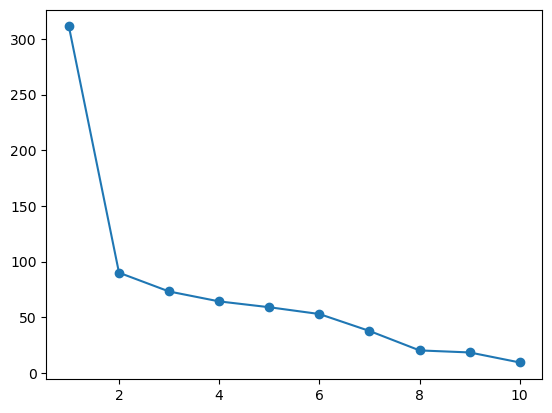

In [283]:
u, s, vt = np.linalg.svd(A)
plt.plot(np.arange(1, len(s) + 1), s, marker='o')
plt.show()

In [284]:
k = 2

In [285]:
def optimal_s_lambda(A, C, k):
    m = np.shape(A)[0]
    u, s, vt = np.linalg.svd(A)
    tail = s[k:]
    k_bar_k = (np.linalg.norm(A, ord = "fro") / np.min(tail)) / np.sqrt(len(tail))   #normalized tail condition number
    
    optimal_s = np.ceil(C * k * np.log(m * k_bar_k))
    optimal_lambda = (k / m) * np.mean(tail ** 2)
    return optimal_s, optimal_lambda

In [293]:
def update_rho_adaptive(residuals, i, p, r_hat_prev):
    """
    Adaptive rho update based on averaged residual norm squared ratios.
    """
    if len(residuals) < 2 * p:
        return 0.9, r_hat_prev  # default fallback

    eps_t = np.mean([r**2 for r in residuals[-p:]])
    eps_tp = np.mean([r**2 for r in residuals[-2*p:-p]])
    r_ip = eps_t / eps_tp

    a_i = (i + 1) ** np.log(i + 1)
    alpha = (a_i - 1) / a_i

    r_hat = alpha * r_hat_prev + (1 - alpha) * r_ip
    rho_new = 1 - r_hat ** (1 / p)
    return rho_new, r_hat

In [294]:
def kaczmarz(A, b, lamb, rho, eta, n_steps, block_size, x_true = None):
    m, n = A.shape
    x = np.zeros((n,1))
    residuals = []
    update_norms = []
    errors = []
    
    mtm = 0
    r_hat = 1.0
    p = 10
    checkpoint_idx = 1
    
    for t in range(n_steps):
        tau = np.random.choice(m, block_size, replace=False)
        A_tau = A[tau, :]
        b_tau = b[tau]
    
        #regularized projection: 
        w = A_tau.T @ np.linalg.inv(A_tau @ A_tau.T + lamb * np.eye(block_size)) @ (A_tau @ x - b_tau)
        mtm_new = ((1 - rho)/(1 + rho))*(mtm - w)
        x_new = x - w + eta * mtm_new

        #storing residual, which should be getting smaller 
        residuals.append(np.linalg.norm(A @ x_new - b))

        #storing update size
        update_norms.append(np.linalg.norm(x_new - x))

        #storing error
        if x_true is not None:
            errors.append(np.linalg.norm(x_new - x_true))

        if t % p == 0 and t >= 2 * p:
            rho, r_hat = update_rho_adaptive(residuals, checkpoint_idx, p, r_hat)
            checkpoint_idx += 1
            
        x = x_new
        mtm = mtm_new

    return x, residuals, update_norms, errors

In [296]:
def verify():
     #Run Kaczmarz
    #block size, lambda
    s = optimal_s_lambda(A, 1, k)[0].astype(int)
    lamb = optimal_s_lambda(A, 1, k)[1]
    eta = s/(2*n)
    x_kacz, residuals, update_norms, errors = kaczmarz(A, b, lamb = lamb, rho = 0, eta = eta, n_steps = 25, block_size = s, x_true = x_true)

    #Plot metrics
    fig, axs = plt.subplots(3, 1, figsize=(10, 10))

    axs[0].plot(residuals)
    axs[0].set_title("1. Residual Norm ||Ax - b|| (inconsistent system)")
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel("Residual")

    axs[1].plot(update_norms)
    axs[1].set_title("2. Update Norm ||x_{t+1} - x_t||")
    axs[1].set_xlabel("Iteration")
    axs[1].set_ylabel("Update Size")

    axs[2].plot(errors)
    axs[2].set_title("3. Error Norm ||x - x_true||")
    axs[2].set_xlabel("Iteration")
    axs[2].set_ylabel("Error")

    plt.tight_layout()
    plt.show()


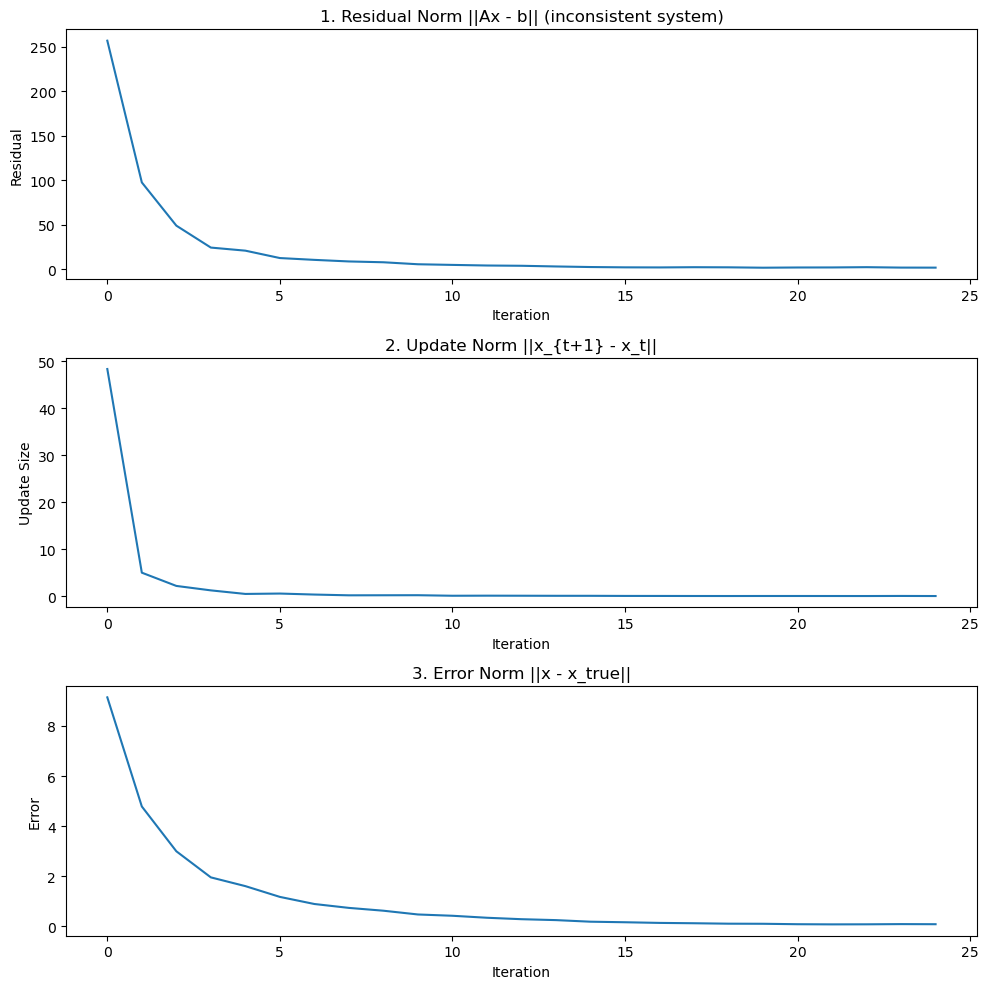

In [290]:
verify()